<a href="https://colab.research.google.com/github/YangJiao85/disaster-tweets-kaggle/blob/master/disaster_tweets_MLmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disaster Tweets 

This notebook will build a machine learning model that predicts which Tweets are about real disasters and which one's aren't. 

## Set up

Set up Kaggle environment and essential modules.

In [2]:
# Load essential modules
import numpy as np 
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

import re

import sklearn.model_selection as ms
import sklearn.metrics as skm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Google colab Kaggle setting

os.environ['KAGGLE_USERNAME'] =  <kaggle_username>  # Kaggle username from json file
os.environ['KAGGLE_KEY'] =  <kaggle_key>    # Kaggle key from json file

!kaggle competitions download -c 'nlp-getting-started'


  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 41.9MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 54.9MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 59.8MB/s]


In [0]:
# load data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')


## Extract feature vectors


- id
- keyword
- location
- text
- target

In [0]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD

# reshape 2D to 1D
class trans_ravel(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.ravel()

# 
url = re.compile(r'https?://(\S+)')
tag = re.compile(r'\#(\S+)')
at = re.compile(r'\@(\S+)')

# clean text to remove url, tag, at
class trans_textclean(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.replace(url, r' ')
        X = X.replace(tag, r' ')
        X = X.replace(at, r' ')
        return X

class trans_extracttag(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.DataFrame(X.apply(lambda x: ' '.join(re.findall(tag, x))))

class trans_extractat(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.DataFrame(X.apply(lambda x: ' '.join(re.findall(at, x))))

class trans_extractkw(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.DataFrame(X.str.split(pat = '%20').str.join(' '))
       

# keyword
kw_vec = Pipeline([
    ('kw_extract', trans_extractkw()),
    ('kw_imp', SimpleImputer(strategy='constant')),
    ('kw_ravel', trans_ravel()),
    ('kw_vect', TfidfVectorizer())                   
    ], verbose = True)

# location
loc_vec = Pipeline([
    ('loc_imp', SimpleImputer(strategy = 'constant')),
    ('loc_ohe', OneHotEncoder(handle_unknown='ignore'))                    
    ], verbose = True)

# text
text_vec = Pipeline([
    ('text_clean', trans_textclean()),                 
    ('text_tfidf', TfidfVectorizer()),
    #('text_tsvd', TruncatedSVD())                     
    ], verbose = True)

tag_vec = Pipeline([
    ('tag_extract', trans_extracttag()),
    ('tag_imp', SimpleImputer(strategy = 'constant')),
    ('tag_ravel', trans_ravel()),
    ('tag_vect', TfidfVectorizer())                
    ], verbose = True)

at_vec = Pipeline([
    ('at_extract', trans_extractat()),
    ('at_imp', SimpleImputer(strategy = 'constant')),
    ('at_ravel', trans_ravel()),
    ('at_vect', TfidfVectorizer())               
    ], verbose = True)



In [0]:
# 
transformer = ColumnTransformer([
    ('kw_vec', kw_vec, 'keyword'),
    ('loc_vec', loc_vec, ['location']),
    ('text_vec', text_vec, 'text'),
    ('tag_vec', tag_vec, 'text'),
    ('at_vec', at_vec, 'text')                                 
], remainder = 'drop')

In [0]:
X_train, X_test, y_train, y_test = ms.train_test_split(
    df_train[['keyword', 'location', 'text']],
    df_train['target'],    
    test_size = 0.3,
    random_state = 1234
)

In [8]:
text_vec.fit(X_train['text'])
X_text = text_vec.transform(X_train['text'])
X_text.shape

[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.1s


(5329, 11184)

In [9]:
loc_vec.fit(X_train[['location']])
X_location = loc_vec.transform(X_train[['location']])
X_location.toarray().shape

[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s


(5329, 2501)

In [10]:
tag_vec.fit(X_train['text'])
X_tag = tag_vec.transform(X_train['text'])
X_tag.toarray().shape

[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s


(5329, 1497)

In [11]:
at_vec.fit(X_train['text'])
X_at = at_vec.transform(X_train['text'])
X_at.toarray().shape

[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing at_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing at_vect, total=   0.0s


(5329, 1677)

[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s


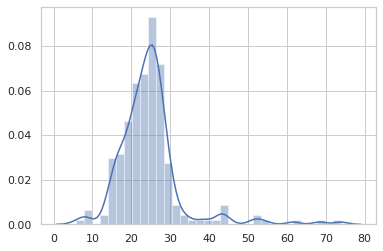

In [12]:
kw_vec.fit(X_train['keyword'])
X_kw = kw_vec.transform(X_train['keyword'])
X_kw.toarray().shape
kw_vec.get_params()['steps'][3][1].vocabulary_
kw_count = X_kw.toarray().sum(axis=0)
sns.distplot(kw_count)

61

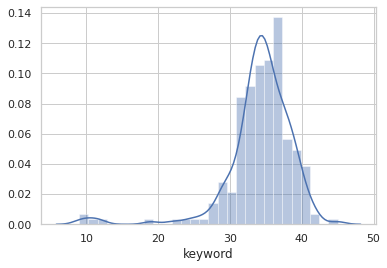

In [13]:
sns.distplot(df_train['keyword'].value_counts())
pd.isna(df_train['keyword']).sum()

In [14]:
transformer.fit(X_train)
X_train_trans = transformer.transform(X_train)
X_train_trans.toarray().shape

[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.1s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

(5329, 17089)

## Model

### Some functions

In [0]:
def perform_grid_search(pip_clf, tuned_parameters):
    from pprint import pprint
    from time import time
    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected block

        # find the best parameters
        grid_search = ms.GridSearchCV(pip_clf, tuned_parameters, n_jobs=-1, 
                                  verbose=1)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pip_clf.steps])
        print("parameters to be tuned:")
        pprint(tuned_parameters)
        t0 = time()
        grid_search.fit(X_train, y_train)

        print("Best parameters set found on train set:\n")
        print(grid_search.best_params_)
        print("Grid scores on train set:\n")
        means = grid_search.cv_results_['mean_test_score']
        stds = grid_search.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("{:.3f} (+/-{:.3f}) for {}".format(mean, std, params))

        print("\nDetailed classification report:\n")
        y_pred = grid_search.predict(X_test)
        print(skm.classification_report(y_test, y_pred))
    return
    


In [0]:
def print_sub_csv(pip_clf, sub_file = 'submission.csv', ldl = False):
    y_pred = pip_clf.predict(df_test)
    df_sub = pd.DataFrame(data={
        'id': df_test['id'],
        'target': y_pred
    })
    df.head()
    df_sub.to_csv(sub_file, index=False)

    if(ldl):
        from google.colab import files
        files.download(sub_file)
    
    return

In [0]:
X_train, X_test, y_train, y_test = ms.train_test_split(
    df_train[['keyword', 'location', 'text']],
    df_train['target'],
    test_size = 0.3,
    random_state = 1234
)

In [0]:
def predict_submit(pip_clf, file_sub = 'submission.csv', file_local = True, 
                   sub_to_kaggle = False, sub_message = 'Prediction with ML model'):
    from google.colab import files
    y_pred=pip_svc.predict(df_test)
    df_sub = pd.DataFrame(data = {
                         'id': df_test['id'],
                         'target': y_pred})
    print(df_sub.head())
    df_sub.to_csv(file_sub, index=False)
    print(df_sub['target'].value_counts())
    if(file_local):
        files.download(file_sub)
    if(sub_to_kaggle):
        os.system("kaggle competitions submit -c nlp-getting-started -f '{}' -m '{}'".format(file_sub, sub_message))
    return

### Support Vector Classifier (SVC)

In [0]:
from sklearn.svm import LinearSVC
pip_svc = Pipeline([
    ('trans', transformer),
    ('clf', LinearSVC())                    
    ], verbose = True)



In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_train[['keyword', 'location', 'text']], df_train['target'],
    test_size = 0.3, random_state = 1234
)

pip_fit = pip_svc.fit(X_train, y_train)


[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.1s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [21]:
y_pred = pip_svc.predict(X_test)
print(skm.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1288
           1       0.79      0.72      0.75       996

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.79      2284
weighted avg       0.79      0.79      0.79      2284



#### Grid search with cross validation

In [46]:
tuned_parameters = ({
    'trans__text_vec__text_tfidf__max_df': (0.1, 0.3, 0.5, 1.0),
    'trans__text_vec__text_tfidf__min_df': (1, 2, 5),
    'trans__text_vec__text_tfidf__ngram_range': ((1,1), (1,2), (2,2))
})

perform_grid_search(pip_svc, tuned_parameters)

Performing grid search...
pipeline: ['trans', 'clf']
parameters to be tuned:
{'trans__text_vec__text_tfidf__max_df': (0.1, 0.3, 0.5, 1.0),
 'trans__text_vec__text_tfidf__min_df': (1, 2, 5),
 'trans__text_vec__text_tfidf__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   54.6s finished


[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.3s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [36]:
pip_svc.set_params(trans__text_vec__text_tfidf__max_df = 0.5)
pip_svc.set_params(trans__text_vec__text_tfidf__min_df = 1)
pip_svc.set_params(trans__text_vec__text_tfidf__ngram_range = (1,2))

tuned_parameters = ({
    'trans__kw_vec__kw_vect__max_df': (0.1, 0.3, 0.5, 1.0),
    'trans__kw_vec__kw_vect__min_df': (1, 2, 5),
    'trans__kw_vec__kw_vect__ngram_range': ((1,1), (1,2), (2,2))
})

perform_grid_search(pip_svc, tuned_parameters)

Performing grid search...
pipeline: ['trans', 'clf']
parameters to be tuned:
{'trans__kw_vec__kw_vect__max_df': (0.1, 0.3, 0.5, 1.0),
 'trans__kw_vec__kw_vect__min_df': (1, 2, 5),
 'trans__kw_vec__kw_vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.3s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [40]:
pip_svc.set_params(trans__kw_vec__kw_vect__max_df = 0.1)
pip_svc.set_params(trans__kw_vec__kw_vect__min_df = 1)
pip_svc.set_params(trans__kw_vec__kw_vect__ngram_range = (2,2))
tuned_parameters = ({
    'trans__tag_vec__tag_vect__max_df': (0.1, 0.2, 0.5, 1.),
    'trans__tag_vec__tag_vect__min_df': (1, 2, 3),
    'trans__tag_vec__tag_vect__ngram_range': ((1,1), (1,2), (2,2)), 
})

perform_grid_search(pip_svc, tuned_parameters)

Performing grid search...
pipeline: ['trans', 'clf']
parameters to be tuned:
{'trans__tag_vec__tag_vect__max_df': (0.1, 0.2, 0.5, 1.0),
 'trans__tag_vec__tag_vect__min_df': (1, 2, 3),
 'trans__tag_vec__tag_vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.3s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [42]:
pip_svc.set_params(trans__tag_vec__tag_vect__max_df = 0.1)
pip_svc.set_params(trans__tag_vec__tag_vect__min_df = 1)
pip_svc.set_params(trans__tag_vec__tag_vect__ngram_range = (1,2))

tuned_parameters = ({
    'trans__at_vec__at_vect__max_df': (0.1, 0.3, 0.5, 1),
    'trans__at_vec__at_vect__min_df': (1, 2, 3),
    'trans__at_vec__at_vect__ngram_range': ((1,1), (1,2), (2,2)),
})

perform_grid_search(pip_svc, tuned_parameters)

Performing grid search...
pipeline: ['trans', 'clf']
parameters to be tuned:
{'trans__at_vec__at_vect__max_df': (0.1, 0.3, 0.5, 1),
 'trans__at_vec__at_vect__min_df': (1, 2, 3),
 'trans__at_vec__at_vect__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.1min finished


[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.3s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [54]:
pip_svc.set_params(trans__kw_vec__kw_vect__max_df = 1.)
pip_svc.set_params(trans__kw_vec__kw_vect__min_df = 1)
pip_svc.set_params(trans__kw_vec__kw_vect__ngram_range = (1,1))
pip_svc.set_params(trans__text_vec__text_tfidf__max_df = .5)
pip_svc.set_params(trans__text_vec__text_tfidf__min_df = 1)
pip_svc.set_params(trans__text_vec__text_tfidf__ngram_range = (1,2))
pip_svc.set_params(trans__tag_vec__tag_vect__max_df = 1.)
pip_svc.set_params(trans__tag_vec__tag_vect__min_df = 1)
pip_svc.set_params(trans__tag_vec__tag_vect__ngram_range = (1,1))
pip_svc.set_params(trans__at_vec__at_vect__max_df = 1.)
pip_svc.set_params(trans__at_vec__at_vect__min_df = 1)
pip_svc.set_params(trans__at_vec__at_vect__ngram_range = (1,1))

tuned_parameters = ({
    'trans__text_vec__text_tfidf__max_df': (0.1, 0.5, 1.0),
    'trans__text_vec__text_tfidf__ngram_range': ((1,1), (1,2), (2,2)),
    'clf__penalty': ('l1', 'l2',),
    'clf__C': (0.1, 0.5, 1.0, 2.0, 10),
})

perform_grid_search(pip_svc, tuned_parameters)

Performing grid search...
pipeline: ['trans', 'clf']
parameters to be tuned:
{'clf__C': (0.1, 0.5, 1.0, 2.0, 10),
 'clf__penalty': ('l1', 'l2'),
 'trans__text_vec__text_tfidf__max_df': (0.1, 0.5, 1.0),
 'trans__text_vec__text_tfidf__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.3min finished


[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.1s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [69]:
pip_svc.set_params(trans__text_vec__text_tfidf__max_df = 0.5)
pip_svc.set_params(trans__text_vec__text_tfidf__ngram_range = (1,1))
pip_svc.set_params(clf__penalty = 'l2')
pip_svc.set_params(clf__C = 0.1)

pip_svc.fit(X_train, y_train)
y_pred = pip_svc.predict(X_test)
print(skm.classification_report(y_test, y_pred))

[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.1s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [70]:
predict_submit(pip_svc, file_sub='sub_disaster_tweets_Tfidf_SVC.csv', file_local=True, 
               sub_to_kaggle=True, sub_message='Tfidf_SVC_CrossValidation')

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
0    2082
1    1181
Name: target, dtype: int64


### Gradient Boosting Decision Trees (GBDT)

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbc = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=.1, 
    max_leaf_nodes=10,
    subsample=0.5, 
    random_state=0
    )

pip_gbc = Pipeline([
    ('trans', transformer),
    ('clf_gbc', clf_gbc)                    
    ], verbose = True)

In [60]:
X_train, X_test, y_train, y_test = ms.train_test_split(
    df_train[['keyword', 'location', 'text']], df_train['target'],
    test_size = 0.3, random_state = 1234
    )

pip_gbc_fit = pip_gbc.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.1s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [61]:
y_pred = pip_gbc.predict(X_test)
print(skm.classification_report(y_test, y_pred))
print(pip_gbc.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.73      0.87      0.80      1288
           1       0.78      0.59      0.67       996

    accuracy                           0.75      2284
   macro avg       0.76      0.73      0.73      2284
weighted avg       0.75      0.75      0.74      2284

0.749124343257443


#### Grid search with cross validation

In [66]:
tuned_parameters = {
    'clf_gbc__n_estimators': (10, 100, 200, 400),
    'clf_gbc__learning_rate': (1., 0.5, 0.1),
    'clf_gbc__max_leaf_nodes': (2, 5, 10, 20),
}

perform_grid_search(pip_gbc, tuned_parameters)

Performing grid search...
pipeline: ['trans', 'clf_gbc']
parameters to be tuned:
{'clf_gbc__learning_rate': (1.0, 0.5, 0.1),
 'clf_gbc__max_leaf_nodes': (2, 5, 10, 20),
 'clf_gbc__n_estimators': (10, 100, 200, 400)}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 10.1min finished


[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.1s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [67]:
pip_gbc.set_params(clf_gbc__max_leaf_nodes = 5)
tuned_parameters = {
    'clf_gbc__learning_rate': (0.02, 0.05, 0.1, 0.5),
    'clf_gbc__n_estimators': (100, 400, 1000),
}

perform_grid_search(pip_gbc, tuned_parameters)

Performing grid search...
pipeline: ['trans', 'clf_gbc']
parameters to be tuned:
{'clf_gbc__learning_rate': (0.02, 0.05, 0.1, 0.5),
 'clf_gbc__n_estimators': (100, 400, 1000)}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.4min finished


[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.1s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel

In [68]:
pip_gbc.set_params(clf_gbc__learning_rate = 0.1)
pip_gbc.set_params(clf_gbc__n_estimators = 400)

pip_gbc.fit(X_train, y_train)
y_pred = pip_gbc.predict(X_test)
print(skm.classification_report(y_test, y_pred))

[Pipeline] ........ (step 1 of 4) Processing kw_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing kw_imp, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing kw_ravel, total=   0.0s
[Pipeline] ........... (step 4 of 4) Processing kw_vect, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing loc_imp, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing loc_ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing text_clean, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing text_tfidf, total=   0.1s
[Pipeline] ....... (step 1 of 4) Processing tag_extract, total=   0.0s
[Pipeline] ........... (step 2 of 4) Processing tag_imp, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing tag_ravel, total=   0.0s
[Pipeline] .......... (step 4 of 4) Processing tag_vect, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing at_extract, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing at_imp, total=   0.0s
[Pipel